In [1]:
import pandas as pd
# from pandas_profiling import ProfileReport

from num2words import num2words
import re, unicodedata
# import contractions
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import nltk

In [2]:
# %conda install -c conda-forge contractions

# Preparacion de ambiente

In [3]:
# Punkt permite separar un texto en frases.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ernes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ernes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ernes\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Exploracion de datos

In [6]:
df_raw = pd.read_excel('cat_6716.xlsx')

In [7]:
# Contar valores nulos
df_raw.isnull().sum()

Textos_espanol    0
sdg               0
dtype: int64

In [8]:
# Contar duplicados
df_raw.duplicated().sum()

0

In [9]:
df_raw.head()

,Textos_espanol,sdg
0,"Es importante destacar que, en un año de sequí...",6
1,Hay una gran cantidad de literatura sobre Aust...,6
2,"Los procesos de descentralización, emprendidos...",6
3,Esto puede tener consecuencias sustanciales pa...,6
4,La función de beneficio también incorpora pará...,6


In [10]:
textos = df_raw.copy()
textos['Conteo'] = [len(x) for x in textos['Textos_espanol']]
textos['Moda'] = [max(set(x.split(' ')), key = x.split(' ').count) for x in textos['Textos_espanol']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Textos_espanol']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Textos_espanol']]

# Se realiza un perfilamiento de los datos con la libre pandas profiling
# ProfileReport(textos)

# Preparacion de datos

### Separar en datos de entrenamiento y prueba

In [11]:
X, Y = df_raw['Textos_espanol'], df_raw['sdg']
Y = Y.astype(int)
Y

0        6
1        6
2        6
3        6
4        6
        ..
2995    16
2996    16
2997    16
2998    16
2999    16
Name: sdg, Length: 3000, dtype: int32

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [13]:
X_train.shape, Y_train.shape


((2400,), (2400,))

In [14]:
X_test.shape, Y_test.shape

((600,), (600,))

In [15]:
X_train.head()

2370    Lograr el respeto de los derechos humanos por ...
1774    Diseño de proyectos sostenibles de electrifica...
731     En las partes españolas de las cuencas del Due...
271     Garantizar que los arreglos de gobernanza ayud...
1077    Además, a nivel de plantas y unidades, no hay ...
Name: Textos_espanol, dtype: object

#### **3.1 Limpieza de los datos**

https://medium.com/datos-y-ciencia/preprocesamiento-de-datos-de-texto-un-tutorial-en-python-5db5620f1767

In [16]:
class TextTransformer(BaseEstimator, TransformerMixin):
    """
    Se encarga de remover caracteres ascii, convertir a minúsculas, quitar puntuación y transformar números a letras
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.apply(lambda x: self.tokenize_and_process_text(x))
        X = X.str.replace('Ã³', 'o')
        return X

    def tokenize_and_process_text(self, text):
        tokens = word_tokenize(text, language='spanish')
        processed_tokens = [self.remove_non_ascii(token) for token in tokens]
        processed_tokens = [self.to_lowercase(token) for token in processed_tokens]
        processed_tokens = [self.remove_punctuation(token) for token in processed_tokens]
        processed_tokens = [self.replace_numbers(token) for token in processed_tokens]
        processed_tokens = [self.remove_stopwords(token) for token in processed_tokens]
        processed_text = ' '.join(processed_tokens)
        return processed_text

    def remove_non_ascii(self, word):
        return unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    def to_lowercase(self, word):
        return word.lower()

    def remove_punctuation(self, word):
        return re.sub(r'[^\w\s]', '', word)

    def replace_numbers(self, word):
        if word.isdigit():
            return num2words(word, lang='es')
        return word    
    
    def remove_stopwords(self, word):
        stop_words = stopwords.words('spanish')
        if word in stop_words:
            return ''
        return word

In [17]:
class NormalizeTokens(BaseEstimator, TransformerMixin):
    """Hace lematización de las palabras"""

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.apply(lambda x: self.lemmatize_text(x))
        return X
    
    def lemmatize_text(self, text):
        lemmatizer = nltk.stem.WordNetLemmatizer()
        tokens = word_tokenize(text, language='spanish')
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        lemmatized_text = ' '.join(lemmatized_tokens)
        # print(lemmatized_text + '\n')
        return lemmatized_text

In [18]:
# Stemmer de Contexto (te la meto sin pretexto)
"""
stemmer = Stemmer(lenguaje='español')
X_train.head()

X_train = X_train.apply(lambda x: stem_texto(texto=x, stemmer=stemmer))
X_train.head()
"""

"\nstemmer = Stemmer(lenguaje='español')\nX_train.head()\n\nX_train = X_train.apply(lambda x: stem_texto(texto=x, stemmer=stemmer))\nX_train.head()\n"

In [19]:
pipeline = Pipeline(
    [
        ("text_transformer", TextTransformer()),
        ("normalize_tokens", NormalizeTokens()),
        ("tfidf", TfidfVectorizer(stop_words=stopwords.words('spanish'))),
        ("classifier", MultinomialNB())
    ]
)   
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('text_transformer', TextTransformer()),
                ('normalize_tokens', NormalizeTokens()),
                ('tfidf',
                 TfidfVectorizer(stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...])),
                ('classifier', MultinomialNB())])

In [20]:
Y_pred = pipeline.predict(X_test)


In [21]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate the classification report
class_report = classification_report(Y_test, Y_pred)
print("Classification Report:")
print(class_report)

# Calculate the number of mislabeled points
mislabel_count = (Y_test != Y_pred).sum()
print(f"Number of mislabeled points: {mislabel_count}")

# Calculate the percentage of correct guesses
correct_guesses = (len(Y_test) - mislabel_count) / len(Y_test) * 100
print(f"Percentage of correct guesses: {correct_guesses:.2f}%")


Confusion Matrix:
[[219  16   2]
 [  3 184   0]
 [  1   0 175]]
Classification Report:
              precision    recall  f1-score   support

           6       0.98      0.92      0.95       237
           7       0.92      0.98      0.95       187
          16       0.99      0.99      0.99       176

    accuracy                           0.96       600
   macro avg       0.96      0.97      0.96       600
weighted avg       0.96      0.96      0.96       600

Number of mislabeled points: 22
Percentage of correct guesses: 96.33%


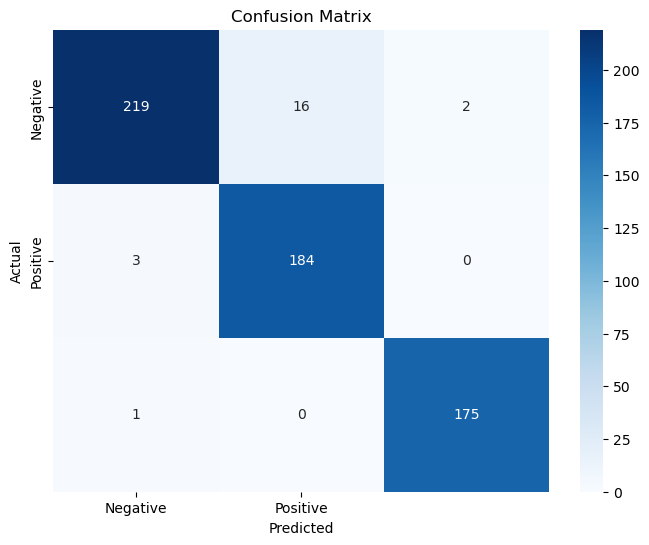

In [22]:
# Print confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
